# Convolutional Neural Network with Attention Mechanisms

## Overview

A Convolutional Neural Network (CNN) model is compared against classical machine learning models (e.g., Support Vector Machine) in a multi-label text classification problem. To be specific, these models will predict the severity of sucide risk from Reddit posts. You can refer to this [link](https://dl.acm.org/doi/10.1145/3308558.3313698) for the original research conducted by Manas, et. al in 'Knowledge-aware assessment of severity of suicide risk for early intervention'. 

The research in the aforementioned paper will be replicated, and the ablations made to the original research are to include an attention mechanism to the original CNN model as well as testing other classical machine learning models.

In [1]:
# Libraries, raw input data, word embeddings, and hyperparameters are documented herein.
# Note, the skeleton code used to create this notebook comes from: https://github.com/jpsain/Suicide-Severity
# The academic research paper referenced is:
# # Paper: "Knowledge-aware Assessment of Severity of Suicide Risk for Early Intervention"

import csv
import string
# import sys ## LWCQ
from nltk import word_tokenize
from gensim.models.keyedvectors import KeyedVectors
import numpy as np
from keras.utils.np_utils import to_categorical
import datetime, time
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Input, MaxPool2D
from keras.layers import Conv2D, GlobalAveragePooling1D, MaxPooling2D
from keras.layers import Concatenate
from keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

ip_txt_file = '../Data/500_Reddit_users_posts_labels.csv'  # CSV file: "User", "Post", "Label"

w2v_file = {'file': '../Data/english_conceptnet.txt', 'is_binary': False}

op_result_file_root = '../results/cv/Result_-Label_Classification.tsv'
op_img_file_root = '../results/images/CFMatrix_-Label_Classification.png'

lexicon_indicator_file = '../lexicon/suicidal_indicator.csv'
lexicon_ideation_file = '../lexicon/suicidal_ideation.csv'
lexicon_behavior_file = '../lexicon/suicidal_behavior.csv'
lexicon_attempt_file = '../lexicon/suicidal_attempt.csv'


severity_classes = {'Supportive': 0, 'Indicator': 1, 'Ideation': 2, 'Behavior': 3, 'Attempt': 4}

sys_params = {'emb_dim': 300,
              'max_sent_len': 1500,
              'str_padd': '@PADD',
              'cross_val': 5}

cnn_params = {'no_filters': 100,
              'kernels': [3, 4, 5],
              'channel': 1,
              'c_stride': (1, sys_params['emb_dim']),
              'pad': 'same',
              'ip_shape': (sys_params['max_sent_len'], sys_params['emb_dim'], 1),
              'c_activ': 'relu',
              'drop_rate': 0.3,
              'dense_1_unit': 128,
              'dense_2_unit': 128,
              'dense_activ': 'relu',
              'op_unit': 4,         # 4-Label classification (merging "Supportive" and "Indicator" class for 3+1 label classification scheme, excluding "Supportive" class for 4 label classification scheme)
              'op_unit2': 5,        # 5-Label classification (for 5 label classification scheme)
              'op_activ': 'softmax',
              'l_rate': 0.001,
              'loss': 'categorical_crossentropy',
              'batch': 4,
              'epoch': 50,
              'verbose': 1}

lexicon_params = {'strict_weight': 0.5,     # strict and soft match parameters for suicide severity lexicon features
                  'soft_weight': 0.5}

general_params = {'RANDOM_STATE': 545510477,
                  'n_components': 500,      # principal component analysis feature count
                  'c': 0.15,                # regularization parameter for SVM-L & SVM-RBF
                  'class_weight': 'balanced',
                  'kernel_L': 'linear',
                  'kernel_RBF': 'rbf'}

intermediate_layer = 'flat_drop'    # for extracting features from CNN

## About Raw Data

The 500 samples have been curated from Reddit posts and can be found [here](https://github.com/jpsain/Suicide-Severity) and will be referred to as the 'goldend standard dataset' (../Data/500_Reddit_users_posts_labels.csv). The format of the data in the csv is as follows:

["User", "Post", "Label"]

where
- `User`: contains the anonymzed user id
- `Post`: several posts from user concerning the topic of suicide 
- `Label`: professional classification of the severity of suicide risk for the user

Label can any of the following values: `["Supportive", "Indicator", "Ideation", "Behavior", "Attempt"]`

## 1 Load and Process Data
This section will read the golden standard dataset and preprocess each word in "Post". Internal features will be created using a wod2vec model with [ConceptNet](https://github.com/commonsense/conceptnet-numberbatch) (numberbatch-en-19.08.txt.gz) term vectors see (../Data/english_conceptnet.txt). External features will be created using the [suicide severity lexicon](https://github.com/manasgaur/Knowledge-aware-Assessment-of-Severity-of-Suicide-Risk-for-Early-Intervention) also here (../lexicon/*.csv).

### 1.1 Preprocess the text data
Read from the gold standard dataset and tokenize this raw data as a list of sentences, sentences represented by a list of padded tokens. Note, the word padding (`padd`) and max sentence length (`max_len`) are defined in `sys_params`. This function takes in the gold standard dataset (`ip_filed`) and selectively reads data according the classification scheme (`classification`).

In [2]:
# Read the input CSV file
def read_ip_file(ip_file, classification):

    padd = sys_params['str_padd']
    max_len = sys_params['max_sent_len']
    punctuations = list(string.punctuation)

    x_data, y_data = [], []

    if ip_file:
        with open(ip_file) as csv_file:

            # Exclude the first line (header)
            next(csv_file) ## LWCQ
            csv_reader = csv.reader(csv_file, delimiter=',')

            # Loop through each line
            for row in csv_reader:
                
                sent = row[1]

                label = row[2].strip()                

                # Remove non-ascii characters
                printable = set(string.printable)
                sent = filter(lambda x: x in printable, sent)
                sent = ''.join(sent).lower()

                # Remove punctuation
                lst_tokens = [item.strip("".join(punctuations)) for item in word_tokenize(sent) if
                                item not in punctuations]

                # Strip the sentence if it exceeds the max length
                if len(lst_tokens) > max_len:
                    lst_tokens = lst_tokens[:max_len]

                # Padd the sentence if the length is less than max length
                elif len(lst_tokens) < max_len:
                    for j in range(len(lst_tokens), max_len):
                        lst_tokens.append(padd)

                x_data.append(lst_tokens)
                y_data.append(severity_classes[label])

            if classification=='3+1':
                # if the label is 'Supportive'(label_no=0) or 'Indicator'(label_no=1), then use 0 as class_label
                # otherwise use (label_no - 1): eg. for label_no=2, use 1, the next class after 0;
                y_data = [0 if val in [0, 1] else val-1 for val in y_data]
            elif classification=='4':
                x_data = [val for i, val in enumerate(x_data) if y_data[i] != 0 and y_data[i] in [1, 2, 3, 4]]
                y_data = [val-1 if val in [2, 3, 4] else 0 for val in y_data if val!=0]
            elif classification=='5':
                y_data = y_data

    return x_data, y_data

### 1.2 Feature engineering
Internal features and external features are defined herein and instantiated to later be used in training the machine learning models.

#### 1.2.1 Internal features
A word2vec model will utilize [ConceptNet](https://github.com/commonsense/conceptnet-numberbatch) term vectors to develop word embeddings. Note, these word-embeddings will be formatted differently for CNN models and non-CNN models.

In [3]:
# Vectorize the input data using pretrained word2vec embedding lookup
def vectorize_data(lst_input, model=None):

    padd = sys_params['str_padd']
    wv_size = sys_params['emb_dim']

    # Load the pre-trained word2vec model
    w2v_model = KeyedVectors.load_word2vec_format(w2v_file['file'], binary=w2v_file['is_binary'])

    # Get the word2vec vocabulary
    vocab = w2v_model.key_to_index

    #
    padding_zeros = np.zeros(wv_size, dtype=np.float32)

    x_data = []

    if model == 'CNN':
        # Loop through each sentence
        for sent in lst_input:
            emb = []
            for tok in sent:

                # Zero-padding for padded tokens
                if tok == padd:
                    emb.append(list(padding_zeros))

                # Get the token embedding from the word2vec model
                elif tok in vocab:
                    emb.append(w2v_model[tok].astype(float).tolist())

                # Zero-padding for out-of-vocab tokens
                else:
                    emb.append(list(padding_zeros))

            x_data.append(emb)
    else:
        # Loop through each sentence
        for sent in lst_input:
            emb = []
            for tok in sent:

                # Zero-padding for padded tokens
                if tok == padd:
                    emb.append(padding_zeros)

                # Get the token embedding from the word2vec model
                elif tok in vocab:
                    emb.append(w2v_model[tok].astype(float))

                # Zero-padding for out-of-vocab tokens
                else:
                    emb.append(padding_zeros)

            flat_emb = np.asarray(emb).flatten()
            x_data.append(flat_emb)

    del w2v_model, vocab

    return np.array(x_data)


# Prepare the input data
def read_data(x_data, y_data, model=None):

    # Vectorize the data
    x_data = vectorize_data(x_data, model)

    # Convert into numpy array
    x_data, y_data = np.array(x_data), np.array(y_data)

    return x_data, y_data

#### 1.2.2 External features
Using the [suicide severity lexicon](https://github.com/manasgaur/Knowledge-aware-Assessment-of-Severity-of-Suicide-Risk-for-Early-Intervention), external features will be developed using a strict and soft match criteria.

In [4]:
# Tokenizing lexicon
def create_lexicon(lex_file):

    lex_file = open(lex_file, "r")
    lexicon = lex_file.read().split(",")
    lexicon_lowercase = [phrase.lower() for phrase in lexicon]

    return lexicon_lowercase

# Calculate strict match score
def strict_match_score(tokens, lexicon):

    score = 0
    for token in tokens:
        if token in lexicon:
            score += 1

    return score

# Calculate soft match score
def soft_match_score(tokens, lexicon):

    score = 0
    for token in tokens:
        for phrase in lexicon:
            if token in phrase:
                score += 1
                break

    return score

# Combine strict and soft match scores
def overall_score(tokens, lexicon, strict_weight=lexicon_params['strict_weight'], soft_weight=lexicon_params['soft_weight']):

    strict_score = strict_match_score(tokens, lexicon)
    soft_score = soft_match_score(tokens, lexicon)
    overall_score = (strict_weight * strict_score) + (soft_weight * soft_score)

    return overall_score

# Create lexicon feature matrix
def lexicon_feats(lex_category, ini_x_data):

    x_data_scores = []
    for tokens in ini_x_data:
        score = overall_score(tokens, lex_category)
        x_data_scores.append(score)

    return np.array(x_data_scores)



### 1.3 Instantiate features and final processing
Features will be instantiated using the previously defined feature defintions and final processing touch-ups will be performed.

In [5]:
# Raw data from golden standard dataset will be instantiated into below data structures to be used for developing internal features and external features
ini_x_data_3plus1, ini_y_data_3plus1 = read_ip_file(ip_txt_file, classification='3+1')
ini_x_data_4, ini_y_data_4 = read_ip_file(ip_txt_file, classification='4')
ini_x_data_5, ini_y_data_5 = read_ip_file(ip_txt_file, classification='5')
ini_x_data, ini_y_data = ini_x_data_5, ini_y_data_5 # carries all original data and labels

# Internal features developed for non-CNN models are instantiated using previously instantiated reference raw data
x_data_3plus1, y_data_3plus1 = read_data(ini_x_data_3plus1, ini_y_data_3plus1)
x_data_4, y_data_4 = read_data(ini_x_data_4, ini_y_data_4)
x_data_5, y_data_5 = read_data(ini_x_data_5, ini_y_data_5)
x_data, y_data = x_data_5, y_data_5 # carries all original data and labels

# Internal features developed for CNN models are instantiated using previously instantiated reference raw data
x_data_CNN_3plus1, y_data_CNN_3plus1 = read_data(ini_x_data_3plus1, ini_y_data_3plus1, model='CNN')
x_data_CNN_4, y_data_CNN_4 = read_data(ini_x_data_4, ini_y_data_4, model='CNN')
x_data_CNN_5, y_data_CNN_5 = read_data(ini_x_data_5, ini_y_data_5, model='CNN')
x_data_CNN, y_data_CNN = x_data_CNN_5, y_data_CNN_5 # carries all original data and labels

Internal features have a dimensionality of `450000`, this spatial dimensionality is not needed for the classical machine learning models to be studied here as they inherently do not contain any sequential understanding of data. Thus, a principal component analysis is used to reduce the dimensionality of internal features to `500` while still retaining more than `99.9%` of critical data. These PCA internal features will be used to train non-CNN models. 

In [6]:
# PCA to reduce dimensionality of vectorized data (300 vector sized embeddings)
from sklearn.decomposition import PCA

pca_model = PCA(n_components=general_params['n_components'])
pca_model.fit(x_data)
print("Sum of variance ratios: ", sum(pca_model.explained_variance_ratio_))
# previous test indicate the following variances
# 400 - 0.9735561383783489
# 450 - 0.9924935178731535
# 500 - 0.9999999999999999

x_data_PCA_3plus1 = pca_model.transform(x_data_3plus1)
x_data_PCA_4 = pca_model.transform(x_data_4)
x_data_PCA_5 = pca_model.transform(x_data_5)

Sum of variance ratios:  0.9999999999999999


The [suicide severity lexicon](https://github.com/manasgaur/Knowledge-aware-Assessment-of-Severity-of-Suicide-Risk-for-Early-Intervention) is instantiated for all, but `Supportive` from the `severity_classes` as the lexicon only covers the four top-most classes, `Indicator`, `Ideation`, `Behavior`, and `Attempt`. External features are then created for all CNN models, `3+1-Label Classification`, `4-Label Classification`, and `5-Label Classification`.

In [7]:
## Create external features

# creating lexicon corpus
lex_indicator = create_lexicon(lexicon_indicator_file)
lex_ideation = create_lexicon(lexicon_ideation_file)
lex_behavior = create_lexicon(lexicon_behavior_file)
lex_attempt = create_lexicon(lexicon_attempt_file)

# ext feats
x_data_ext_feat_lex_indicator = lexicon_feats(lex_indicator, ini_x_data)
x_data_ext_feat_lex_ideation = lexicon_feats(lex_ideation, ini_x_data)
x_data_ext_feat_lex_behavior = lexicon_feats(lex_behavior, ini_x_data)
x_data_ext_feat_lex_attempt = lexicon_feats(lex_attempt, ini_x_data)

# combine into one external feats matrix
x_data_ext_feat = np.vstack((x_data_ext_feat_lex_indicator, 
                                  x_data_ext_feat_lex_ideation,
                                  x_data_ext_feat_lex_behavior,
                                  x_data_ext_feat_lex_attempt)).T

def get_ext_feat(x_data_ext_feat, y_data, classification):

    if classification=='3+1':
        x_data_ext_feat = x_data_ext_feat
    elif classification=='4':
         x_data_ext_feat = [val for i, val in enumerate(x_data_ext_feat) if y_data[i] != 0 and y_data[i] in [1, 2, 3, 4]]
         x_data_ext_feat = np.array(x_data_ext_feat)
    elif classification=='5':
        x_data_ext_feat = x_data_ext_feat

    return x_data_ext_feat

x_data_ext_feat_3plus1 = get_ext_feat(x_data_ext_feat, y_data, classification='3+1')
x_data_ext_feat_4 = get_ext_feat(x_data_ext_feat, y_data, classification='4')
x_data_ext_feat_5 = get_ext_feat(x_data_ext_feat, y_data, classification='5')


## 2 Evaluation Metrics
### Metrics
The Graded Precision, Graded Recall, and Graded F1-score here are taken as those developed by original paper.

### Visuals/Plots
The confusion matrices are shown at the end of this notebook. 

In [8]:
# Confusion Matrix Function
from sklearn.metrics import confusion_matrix
op_temp = '../results/Result_3+1-Label_Classification.tsv' ## LWCQ

def confusion_matrix_data(op_file):
    y_true = []
    y_pred = []
    with open(op_file) as f:
        counter = 0
        cross_val_id = "Cross_Val:"
        # Read data line by line
        for line in f:
            l=line.splitlines()
            if cross_val_id in l:
                counter += 1
            if counter == 5 and cross_val_id not in l:
                y_val = l[0].split('\t')
                y_true.append(int(y_val[0]))
                y_pred.append(int(y_val[1]))
    return y_true, y_pred, confusion_matrix(y_true, y_pred)



# Compute Precision, Recall, and F1-score
def get_prf1_score(y_true, y_pred):
    tp, fp, fn = 0.0, 0.0, 0.0
    for i in range(len(y_pred)):
        if y_pred[i] == y_true[i]:
            tp += 1
        elif y_pred[i] > y_true[i]:
            fp += 1
        else:
            fn += 1
    if tp == 0:
        tp = 1.0
    if fp == 0:
        fp = 1.0
    if fn == 0:
        fn  = 1.0
    P = tp / (tp + fp)
    R = tp / (tp + fn)
    F = 2 * P * R / (P + R)
    print('\nPrecision: {0}\t Recall: {1}\t F1-Score: {2}'.format(P, R, F))
    return {'P': P, 'R': R, 'F': F}

## 3. Model Development
### 3.1. CNN Model
The architecture for the CNN model to be used is identical across the 3 classification types. Is is described herein.
This section covers the development of models, model architecture, hyperparameters, etc. 

In [9]:
# Returns the CNN model
from keras import layers

def get_cnn_model(classification, attention='NO'):
    seq_len = sys_params['max_sent_len']
    emb_dim = sys_params['emb_dim']

    # Input layers
    l_ip = Input(shape=(seq_len, emb_dim, 1), dtype='float32')

    # Output layer count
    if classification=='3+1' or classification=='4':
        op_units = cnn_params['op_unit']
    elif classification=='5':
        op_units = cnn_params['op_unit2']

    # CNN layers
    lst_convfeat = []
    for filter in cnn_params['kernels']:
        l_conv = Conv2D(filters=cnn_params['no_filters'], kernel_size=(filter, emb_dim), strides=cnn_params['c_stride'],
                        padding=cnn_params['pad'], data_format='channels_last', input_shape=cnn_params['ip_shape'],
                        activation=cnn_params['c_activ'])(l_ip)
        l_pool = MaxPool2D(pool_size=(seq_len, 1))(l_conv)
        lst_convfeat.append(l_pool)

    # Concatenate CNN outputs
    l_concat = Concatenate(axis=1)(lst_convfeat)

    # Self-attention layer and subsequent flatten layer to feed into dropout layer
    if attention=='NO':
        l_flat = Flatten()(l_concat)
    elif attention=='YES':
        num_heads = 2 * op_units # typical to use twice the op_units size
        l_att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=emb_dim)(l_concat, l_concat)
        l_flat = Flatten()(l_att)

    # Intermediate (output for CNN generated features) layer
    l_drop = Dropout(rate=cnn_params['drop_rate'], name='flat_drop')(l_flat)

    # Output layer
    l_op = Dense(units=op_units, activation=cnn_params['op_activ'], name='cnn_op')(l_drop)

    final_model = Model(l_ip, l_op)
    final_model.compile(optimizer=Adam(learning_rate=cnn_params['l_rate']), loss=cnn_params['loss'], metrics=['accuracy'])    # 'categorical_crossentropy'

    return final_model

The CNN model then feeds into this sequential model 

In [10]:
# Returns a MLP model for final classification
def get_mlp_model(ip_dim, classification):

    mlp_model = Sequential()

    if classification=='3+1' or classification=='4':
        mlp_model.add(Dense(units=cnn_params['op_unit'], activation=cnn_params['op_activ'], name='classif_op',input_dim=ip_dim))
    elif classification=='5':
        mlp_model.add(Dense(units=cnn_params['op_unit2'], activation=cnn_params['op_activ'], name='classif_op',input_dim=ip_dim))
    
    mlp_model.compile(optimizer=Adam(learning_rate=cnn_params['l_rate']), loss=cnn_params['loss'], metrics=['accuracy'])
     
    return mlp_model


### 3.2 Non-CNN Models
This section covers the development of models, model architecture, hyperparameters, etc. 

#### SVM, Random Forest, Logistic Regression
Two support vector machines are considered, one with a linear kernel and another with a rbf kernel, random forest classifier, and logistic regression.

In [11]:
# Returns the SVM-L (with linear kernel) model

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Returns the SVM-L (with linear kernel) model
def get_svm_L_model():

    svm_model = SVC(kernel=general_params['kernel_L'], random_state=general_params['RANDOM_STATE'], 
                    class_weight=general_params['class_weight'], C=general_params['c'])

    return svm_model

# Returns the SVM-RBF (with rbf kernel) model
def get_svm_RBF_model():

    svm_model = SVC(kernel=general_params['kernel_RBF'], random_state=general_params['RANDOM_STATE'], 
                    class_weight=general_params['class_weight'], C=general_params['c'])

    return svm_model

# Returns the random forest model
def get_rf_model():

    rf_model = RandomForestClassifier(random_state=general_params['RANDOM_STATE'])

    return rf_model

# Returns the logistic regression model
# this model is an ablation from the initial research and is 
def get_lr_model():

    lr_model = LogisticRegression(random_state=general_params['RANDOM_STATE'])

    return lr_model

## 4 Model Training
In general each cross-validation has 5 folds.

### 4.1 CNN Model

In [ ]:
# instantiate CNN models to test for errors
cnn_model_3plus1 = get_cnn_model(classification='3+1', attention='NO')
cnn_att_model_3plus1 = get_cnn_model(classification='3+1', attention='YES')
cnn_model_4 = get_cnn_model(classification='4', attention='NO')
cnn_model_5 = get_cnn_model(classification='5', attention='NO')

# mlp layers are instantiated now to test for errors
mlp_model_3plus1 = get_mlp_model(ip_dim=500, classification='3+1')
mlp_model_4 = get_mlp_model(ip_dim=500, classification='4')
mlp_model_5 = get_mlp_model(ip_dim=500, classification='5')



Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



In [13]:
# create file for recording results |  sample
def record_results(classification, model='CNN'):
    
    root, ext = op_result_file_root.split('-')
    record = root + model + '_' + classification + '-' + ext

    return record

print(record_results(classification='3+1'))
print(record_results(classification='3+1', model='SVM_L'))


../results/cv/Result_CNN_3+1-Label_Classification.tsv
../results/cv/Result_SVM_L_3+1-Label_Classification.tsv


In [14]:
def cnn_train(model_name, attention, x_data, y_data, classification, x_data_ext=None):
    op_file = record_results(classification=classification, model=model_name)
    with open(op_file, 'w') as of:

        cv_count = 0
        k_score = []

        # Stratified cross-validation
        skf = StratifiedKFold(n_splits=sys_params['cross_val'])
        skf.get_n_splits(x_data, y_data)

        # Run the model for each splits
        for train_index, test_index in skf.split(x_data, y_data):
            cv_count += 1
            print('\nRunning Stratified Cross Validation: {0}/{1}...'.format(cv_count, sys_params['cross_val']))

            x_train, x_test = x_data[train_index], x_data[test_index]
            y_train, y_test = y_data[train_index], y_data[test_index]
    
            # Convert the class labels into categorical
            y_train, y_test = to_categorical(y_train), to_categorical(y_test)

            # Reshape the data for CNN
            x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
            x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

            # External features for this particular split
            if x_data_ext is not None:
                x_ext_train, x_ext_test = x_data_ext[train_index], x_data_ext[test_index]

            # CNN model for training on the embedded text input
            cnn_model = get_cnn_model(classification=classification, attention=attention)
            print(cnn_model.summary())

            # Train the model
            cnn_model.fit(x=x_train, y=y_train, batch_size=cnn_params['batch'], epochs=cnn_params['epoch'], verbose=cnn_params['verbose'])

            # Trained model for extracting features from intermediate layer
            model_feat_extractor = Model(inputs=cnn_model.input, outputs=cnn_model.get_layer(intermediate_layer).output)

            # Get CNN generated features
            train_cnn_feat = model_feat_extractor.predict(x_train)
            test_cnn_feat = model_feat_extractor.predict(x_test)

            # Merge the CNN generated features with the external features
            x_train_features = []
            if x_data_ext is not None:
                for index, cnn_feature in enumerate(train_cnn_feat):
                    tmp_feat = list(cnn_feature)
                    tmp_feat.extend(list(x_ext_train[index])) ## LWCQ ## OFF EXT FEATS
                    x_train_features.append(np.array(tmp_feat))
            else:
                for index, cnn_feature in enumerate(train_cnn_feat):
                    tmp_feat = list(cnn_feature)
                    x_train_features.append(np.array(tmp_feat))

            x_test_features = []
            if x_data_ext is not None:
                for index, cnn_feature in enumerate(test_cnn_feat):
                    tmp_feat = list(cnn_feature)
                    tmp_feat.extend(list(x_ext_test[index])) ## LWCQ ## OFF EXT FEATS
                    x_test_features.append(np.array(tmp_feat))
            else:
                for index, cnn_feature in enumerate(test_cnn_feat):
                    tmp_feat = list(cnn_feature)
                    x_test_features.append(np.array(tmp_feat))


            # Convert the list into numpy array
            x_train_features = np.array(x_train_features)
            x_test_features = np.array(x_test_features)

            del train_cnn_feat, test_cnn_feat

            # Get the MLP model for final classification
            mlp_model = get_mlp_model(ip_dim = len(x_train_features[0]), classification=classification)
            print(mlp_model.summary())

            tc = time.time()

            # Train the MLP model
            mlp_model.fit(x=x_train_features, y=y_train, batch_size=cnn_params['batch'], epochs=cnn_params['epoch'], verbose=cnn_params['verbose'])

            print('\nTime elapsed in training CNN: ', str(datetime.timedelta(seconds=time.time() - tc)))
            del x_train, y_train

            print( '\nEvaluating on Test data...\n')
            # # Print Loss and Accuracy
            model_metrics = mlp_model.evaluate(x_test_features, y_test)

            for i in range(len(model_metrics)):
                print(mlp_model.metrics_names[i], ': ', model_metrics[i])

            y_pred = mlp_model.predict(x_test_features)

            y_pred = np.argmax(y_pred, axis=-1)
            y_test = np.argmax(y_test, axis=-1)

            # Scikit-learn classification report (P, R, F1, Support)
            report = classification_report(y_test, y_pred)
            print(report)

            of.write('Cross_Val:\n')
            for i in range(len(y_pred)):
                of.write('\t'.join([str(y_test[i]), str(y_pred[i])]) + '\n')

            score = get_prf1_score(y_test, y_pred)
            k_score.append(score)

        print(k_score)

        avgP = np.average([score['P'] for score in k_score])
        avgR = np.average([score['R'] for score in k_score])
        avgF = np.average([score['F'] for score in k_score])

        print('\nAfter Stratified Cross Validation Average Precision: {0}\t Recall: {1}\t F1-Score: {2}'.format(avgP, avgR, avgF))


In [15]:
## running 3+1-label cnn-models
train_3_i1 = cnn_train(model_name='CNN_i1', attention='NO', x_data=x_data_CNN_3plus1, y_data=y_data_CNN_3plus1, classification='3+1')
train_3_i1_att = cnn_train(model_name='CNN_i1_att', attention='YES', x_data=x_data_CNN_3plus1, y_data=y_data_CNN_3plus1, classification='3+1')

train_3_i2 = cnn_train(model_name='CNN_i2', attention='NO', x_data=x_data_CNN_3plus1, y_data=y_data_CNN_3plus1, classification='3+1', x_data_ext=x_data_ext_feat_3plus1)
train_3_i2_att = cnn_train(model_name='CNN_i2_att', attention='YES', x_data=x_data_CNN_3plus1, y_data=y_data_CNN_3plus1, classification='3+1', x_data_ext=x_data_ext_feat_3plus1)




Running Stratified Cross Validation: 1/5...
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1500, 300,   0           []                               
                                1)]                                                               
                                                                                                  
 conv2d_12 (Conv2D)             (None, 1500, 1, 100  90100       ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_13 (Conv2D)             (None, 1500, 1, 100  120100      ['input_5[0][0]']                
                                )              

2023-05-08 01:49:10.274658: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


100/100 [==============================] - 4s 35ms/step - loss: 1.2722 - accuracy: 0.3925
Epoch 2/50
100/100 [==============================] - 3s 35ms/step - loss: 1.1155 - accuracy: 0.5750
Epoch 3/50
100/100 [==============================] - 3s 35ms/step - loss: 0.8881 - accuracy: 0.6650
Epoch 4/50
100/100 [==============================] - 3s 35ms/step - loss: 0.7103 - accuracy: 0.7675
Epoch 5/50
100/100 [==============================] - 3s 35ms/step - loss: 0.4965 - accuracy: 0.9075
Epoch 6/50
100/100 [==============================] - 3s 35ms/step - loss: 0.3027 - accuracy: 0.9825
Epoch 7/50
100/100 [==============================] - 3s 35ms/step - loss: 0.1982 - accuracy: 0.9875
Epoch 8/50
100/100 [==============================] - 3s 35ms/step - loss: 0.1176 - accuracy: 1.0000
Epoch 9/50
100/100 [==============================] - 3s 35ms/step - loss: 0.0769 - accuracy: 1.0000
Epoch 10/50
100/100 [==============================] - 3s 35ms/step - loss: 0.0551 - accuracy: 1.0000


/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 1500, 300,   0           []                               
                                1)]                                                               
                                                                                                  
 conv2d_15 (Conv2D)             (None, 1500, 1, 100  90100       ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_16 (Conv2D)             (None, 1500, 1, 100  120100      ['input_6[0][0]']                
                                )                                                           

/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 1500, 300,   0           []                               
                                1)]                                                               
                                                                                                  
 conv2d_18 (Conv2D)             (None, 1500, 1, 100  90100       ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_19 (Conv2D)             (None, 1500, 1, 100  120100      ['input_7[0][0]']                
                                )                                                           

/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 1500, 300,   0           []                               
                                1)]                                                               
                                                                                                  
 conv2d_21 (Conv2D)             (None, 1500, 1, 100  90100       ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_22 (Conv2D)             (None, 1500, 1, 100  120100      ['input_8[0][0]']                
                                )                                                          

/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 1500, 300,   0           []                               
                                1)]                                                               
                                                                                                  
 conv2d_24 (Conv2D)             (None, 1500, 1, 100  90100       ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_25 (Conv2D)             (None, 1500, 1, 100  120100      ['input_9[0][0]']                
                                )                                                          

/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 1500, 300,   0           []                               
                                1)]                                                               
                                                                                                  
 conv2d_27 (Conv2D)             (None, 1500, 1, 100  90100       ['input_10[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_28 (Conv2D)             (None, 1500, 1, 100  120100      ['input_10[0][0]']               
                                )                                                          

/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 1500, 300,   0           []                               
                                1)]                                                               
                                                                                                  
 conv2d_39 (Conv2D)             (None, 1500, 1, 100  90100       ['input_14[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_40 (Conv2D)             (None, 1500, 1, 100  120100      ['input_14[0][0]']               
                                )                                                          

/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 1500, 300,   0           []                               
                                1)]                                                               
                                                                                                  
 conv2d_42 (Conv2D)             (None, 1500, 1, 100  90100       ['input_15[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_43 (Conv2D)             (None, 1500, 1, 100  120100      ['input_15[0][0]']               
                                )                                                          

/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Model: "model_26"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 1500, 300,   0           []                               
                                1)]                                                               
                                                                                                  
 conv2d_45 (Conv2D)             (None, 1500, 1, 100  90100       ['input_16[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_46 (Conv2D)             (None, 1500, 1, 100  120100      ['input_16[0][0]']               
                                )                                                          

/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Model: "model_28"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 1500, 300,   0           []                               
                                1)]                                                               
                                                                                                  
 conv2d_48 (Conv2D)             (None, 1500, 1, 100  90100       ['input_17[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_49 (Conv2D)             (None, 1500, 1, 100  120100      ['input_17[0][0]']               
                                )                                                          

/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Model: "model_42"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 1500, 300,   0           []                               
                                1)]                                                               
                                                                                                  
 conv2d_69 (Conv2D)             (None, 1500, 1, 100  90100       ['input_24[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_70 (Conv2D)             (None, 1500, 1, 100  120100      ['input_24[0][0]']               
                                )                                                          

In [16]:
## running 4-label cnn-models
train_4_i1 = cnn_train(model_name='CNN_i1', attention='NO', x_data=x_data_CNN_4, y_data=y_data_CNN_4, classification='4')
train_4_i1_att = cnn_train(model_name='CNN_i1_att', attention='YES', x_data=x_data_CNN_4, y_data=y_data_CNN_4, classification='4')
train_4_i2 = cnn_train(model_name='CNN_i2', attention='NO', x_data=x_data_CNN_4, y_data=y_data_CNN_4, classification='4', x_data_ext=x_data_ext_feat_4)
train_4_i2_att = cnn_train(model_name='CNN_i2_att', attention='YES', x_data=x_data_CNN_4, y_data=y_data_CNN_4, classification='4', x_data_ext=x_data_ext_feat_4)


Running Stratified Cross Validation: 1/5...
Model: "model_44"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 1500, 300,   0           []                               
                                1)]                                                               
                                                                                                  
 conv2d_72 (Conv2D)             (None, 1500, 1, 100  90100       ['input_25[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_73 (Conv2D)             (None, 1500, 1, 100  120100      ['input_25[0][0]']               
                                )             

/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Model: "model_46"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_26 (InputLayer)          [(None, 1500, 300,   0           []                               
                                1)]                                                               
                                                                                                  
 conv2d_75 (Conv2D)             (None, 1500, 1, 100  90100       ['input_26[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_76 (Conv2D)             (None, 1500, 1, 100  120100      ['input_26[0][0]']               
                                )                                                          

/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Model: "model_48"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 1500, 300,   0           []                               
                                1)]                                                               
                                                                                                  
 conv2d_78 (Conv2D)             (None, 1500, 1, 100  90100       ['input_27[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_79 (Conv2D)             (None, 1500, 1, 100  120100      ['input_27[0][0]']               
                                )                                                          

/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Model: "model_50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_28 (InputLayer)          [(None, 1500, 300,   0           []                               
                                1)]                                                               
                                                                                                  
 conv2d_81 (Conv2D)             (None, 1500, 1, 100  90100       ['input_28[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_82 (Conv2D)             (None, 1500, 1, 100  120100      ['input_28[0][0]']               
                                )                                                          

/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Model: "model_52"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, 1500, 300,   0           []                               
                                1)]                                                               
                                                                                                  
 conv2d_84 (Conv2D)             (None, 1500, 1, 100  90100       ['input_29[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_85 (Conv2D)             (None, 1500, 1, 100  120100      ['input_29[0][0]']               
                                )                                                          

/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Model: "model_54"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_30 (InputLayer)          [(None, 1500, 300,   0           []                               
                                1)]                                                               
                                                                                                  
 conv2d_87 (Conv2D)             (None, 1500, 1, 100  90100       ['input_30[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_88 (Conv2D)             (None, 1500, 1, 100  120100      ['input_30[0][0]']               
                                )                                                          

/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Model: "model_56"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_31 (InputLayer)          [(None, 1500, 300,   0           []                               
                                1)]                                                               
                                                                                                  
 conv2d_90 (Conv2D)             (None, 1500, 1, 100  90100       ['input_31[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_91 (Conv2D)             (None, 1500, 1, 100  120100      ['input_31[0][0]']               
                                )                                                          

/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Model: "model_60"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None, 1500, 300,   0           []                               
                                1)]                                                               
                                                                                                  
 conv2d_96 (Conv2D)             (None, 1500, 1, 100  90100       ['input_33[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_97 (Conv2D)             (None, 1500, 1, 100  120100      ['input_33[0][0]']               
                                )                                                          

/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Epoch 1/50
79/79 [==============================] - 4s 41ms/step - loss: 1.3326 - accuracy: 0.3674
Epoch 2/50
79/79 [==============================] - 3s 37ms/step - loss: 1.2007 - accuracy: 0.4920
Epoch 3/50
79/79 [==============================] - 3s 37ms/step - loss: 1.0352 - accuracy: 0.5591
Epoch 4/50
79/79 [==============================] - 3s 37ms/step - loss: 0.8420 - accuracy: 0.7380
Epoch 5/50
79/79 [==============================] - 3s 37ms/step - loss: 0.6148 - accuracy: 0.9010
Epoch 6/50
79/79 [==============================] - 3s 37ms/step - loss: 0.4044 - accuracy: 0.9649
Epoch 7/50
79/79 [==============================] - 3s 37ms/step - loss: 0.2390 - accuracy: 1.0000
Epoch 8/50
79/79 [==============================] - 3s 36ms/step - loss: 0.1591 - accuracy: 1.0000
Epoch 9/50
79/79 [==============================] - 3s 37ms/step - loss: 0.1071 - accuracy: 1.0000
Epoch 10/50
79/79 [==============================] - 3s 37ms/step - loss: 0.0710 - accuracy: 1.0000
Epoch 11/

/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [17]:
## running 5-label cnn-models
train_5_i1 = cnn_train(model_name='CNN_i1', attention='NO', x_data=x_data_CNN_5, y_data=y_data_CNN_5, classification='5')
train_5_i1_att = cnn_train(model_name='CNN_i1_att', attention='YES', x_data=x_data_CNN_5, y_data=y_data_CNN_5, classification='5')
train_5_i2 = cnn_train(model_name='CNN_i2', attention='NO', x_data=x_data_CNN_5, y_data=y_data_CNN_5, classification='5', x_data_ext=x_data_ext_feat_5)
train_5_i2_att = cnn_train(model_name='CNN_i2_att', attention='YES', x_data=x_data_CNN_5, y_data=y_data_CNN_5, classification='5', x_data_ext=x_data_ext_feat_5)


Running Stratified Cross Validation: 1/5...
Model: "model_84"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_45 (InputLayer)          [(None, 1500, 300,   0           []                               
                                1)]                                                               
                                                                                                  
 conv2d_132 (Conv2D)            (None, 1500, 1, 100  90100       ['input_45[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_133 (Conv2D)            (None, 1500, 1, 100  120100      ['input_45[0][0]']               
                                )             

/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Model: "model_86"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_46 (InputLayer)          [(None, 1500, 300,   0           []                               
                                1)]                                                               
                                                                                                  
 conv2d_135 (Conv2D)            (None, 1500, 1, 100  90100       ['input_46[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_136 (Conv2D)            (None, 1500, 1, 100  120100      ['input_46[0][0]']               
                                )                                                          

/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Model: "model_88"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_47 (InputLayer)          [(None, 1500, 300,   0           []                               
                                1)]                                                               
                                                                                                  
 conv2d_138 (Conv2D)            (None, 1500, 1, 100  90100       ['input_47[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_139 (Conv2D)            (None, 1500, 1, 100  120100      ['input_47[0][0]']               
                                )                                                          

/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Model: "model_90"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_48 (InputLayer)          [(None, 1500, 300,   0           []                               
                                1)]                                                               
                                                                                                  
 conv2d_141 (Conv2D)            (None, 1500, 1, 100  90100       ['input_48[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_142 (Conv2D)            (None, 1500, 1, 100  120100      ['input_48[0][0]']               
                                )                                                          

/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Model: "model_94"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_50 (InputLayer)          [(None, 1500, 300,   0           []                               
                                1)]                                                               
                                                                                                  
 conv2d_147 (Conv2D)            (None, 1500, 1, 100  90100       ['input_50[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_148 (Conv2D)            (None, 1500, 1, 100  120100      ['input_50[0][0]']               
                                )                                                          

/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Model: "model_96"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_51 (InputLayer)          [(None, 1500, 300,   0           []                               
                                1)]                                                               
                                                                                                  
 conv2d_150 (Conv2D)            (None, 1500, 1, 100  90100       ['input_51[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_151 (Conv2D)            (None, 1500, 1, 100  120100      ['input_51[0][0]']               
                                )                                                          

/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Model: "model_100"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_53 (InputLayer)          [(None, 1500, 300,   0           []                               
                                1)]                                                               
                                                                                                  
 conv2d_156 (Conv2D)            (None, 1500, 1, 100  90100       ['input_53[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_157 (Conv2D)            (None, 1500, 1, 100  120100      ['input_53[0][0]']               
                                )                                                         

/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Model: "model_102"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_54 (InputLayer)          [(None, 1500, 300,   0           []                               
                                1)]                                                               
                                                                                                  
 conv2d_159 (Conv2D)            (None, 1500, 1, 100  90100       ['input_54[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_160 (Conv2D)            (None, 1500, 1, 100  120100      ['input_54[0][0]']               
                                )                                                         

/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Model: "model_108"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_57 (InputLayer)          [(None, 1500, 300,   0           []                               
                                1)]                                                               
                                                                                                  
 conv2d_168 (Conv2D)            (None, 1500, 1, 100  90100       ['input_57[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_169 (Conv2D)            (None, 1500, 1, 100  120100      ['input_57[0][0]']               
                                )                                                         

/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

                                1)]                                                               
                                                                                                  
 conv2d_174 (Conv2D)            (None, 1500, 1, 100  90100       ['input_59[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_175 (Conv2D)            (None, 1500, 1, 100  120100      ['input_59[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_176 (Conv2D)            (None, 1500, 1, 100  150100      ['input_59[0][0]']               
                                )                                                                 
          

/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Model: "model_114"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_60 (InputLayer)          [(None, 1500, 300,   0           []                               
                                1)]                                                               
                                                                                                  
 conv2d_177 (Conv2D)            (None, 1500, 1, 100  90100       ['input_60[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_178 (Conv2D)            (None, 1500, 1, 100  120100      ['input_60[0][0]']               
                                )                                                         

/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Model: "model_116"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_61 (InputLayer)          [(None, 1500, 300,   0           []                               
                                1)]                                                               
                                                                                                  
 conv2d_180 (Conv2D)            (None, 1500, 1, 100  90100       ['input_61[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_181 (Conv2D)            (None, 1500, 1, 100  120100      ['input_61[0][0]']               
                                )                                                         

/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Model: "model_118"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_62 (InputLayer)          [(None, 1500, 300,   0           []                               
                                1)]                                                               
                                                                                                  
 conv2d_183 (Conv2D)            (None, 1500, 1, 100  90100       ['input_62[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_184 (Conv2D)            (None, 1500, 1, 100  120100      ['input_62[0][0]']               
                                )                                                         

### 4.2 Non-CNN Models
#### SVM, Random Forest, Logistic Regression
Two support vector machines are considered, one with a linear kernel and another with a rbf kernel.
This section covers the development of models, model architecture, hyperparameters, etc. 

In [18]:
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler

def train(model_name, x_data, y_data, classification, x_data_ext=None):
    op_file = record_results(classification=classification, model=model_name)
    with open(op_file, 'w') as of:

        cv_count = 0
        k_score = []

        # Stratified cross-validation
        skf = StratifiedKFold(n_splits=sys_params['cross_val'])
        skf.get_n_splits(x_data, y_data)

        # Run the model for each splits
        for train_index, test_index in skf.split(x_data, y_data):
            cv_count += 1
            print('\nRunning Stratified Cross Validation: {0}/{1}...'.format(cv_count, sys_params['cross_val']))

            x_train, x_test = x_data[train_index], x_data[test_index]

            if x_data_ext is not None:
                x_ext_train, x_ext_test = x_data_ext[train_index], x_data_ext[test_index]


            # Max absolute scaler for x_train, x_test (internal features)
            x_train = MaxAbsScaler().fit_transform(x_train)
            x_test = MaxAbsScaler().fit_transform(x_test)

            # Min max scaler for x_ext_train, x_ext_test (external features) for lexicon
            if x_data_ext is not None:
                x_ext_train = MinMaxScaler().fit_transform(x_ext_train)
                x_ext_test = MinMaxScaler().fit_transform(x_ext_test)

            # Combine features into just x_train and x_test
            if x_data_ext is not None:
                x_train = np.concatenate((x_train, x_ext_train), axis=1)
                x_test = np.concatenate((x_test, x_ext_test), axis=1)


            y_train, y_test = y_data[train_index], y_data[test_index]

            # # Convert the class labels into categorical
            # y_train, y_test = to_categorical(y_train), to_categorical(y_test)

            # get model
            if model_name == 'SVM_L_i1' or model_name == 'SVM_L_i2':
                model = get_svm_L_model()
            elif model_name == 'SVM_RBF_i1' or model_name == 'SVM_RBF_i2':
                model = get_svm_RBF_model()
            elif model_name == 'RF_i1' or model_name == 'RF_i2':
                model = get_rf_model()
            elif model_name == 'LR_i1' or model_name == 'LR_i2':
                model = get_lr_model()
            

            # svm_model = SVC(kernel='linear', random_state=RANDOM_STATE, class_weight='balanced', C=0.15)
            # svm_model = SVC(kernel='linear', random_state=RANDOM_STATE, C=0.15)

            # SVM model for training on the embedded text input
            model.fit(x_train, y_train)
            # svm_model.fit(x_train, y_train)

            # Print Accuracy
            model_metrics = model.score(x_test, y_test)
            print("Accuracy", ': ', model_metrics)

            # Evaluate the model on the test data
            # y_pred = svm_model.predict(x_test)
            y_pred = model.predict(x_test)

            # Scikit-learn classification report (P, R, F1, Support)
            report = classification_report(y_test, y_pred)
            print(report)

            of.write('Cross_Val:\n')
            for i in range(len(y_pred)):
                of.write('\t'.join([str(y_test[i]), str(y_pred[i])]) + '\n')
            
            score = get_prf1_score(y_test, y_pred)
            k_score.append(score)
        
        print(k_score)

        avgP = np.average([score['P'] for score in k_score])
        avgR = np.average([score['R'] for score in k_score])
        avgF = np.average([score['F'] for score in k_score])

        print('\nAfter Stratified Cross Validation Average Precision: {0}\t Recall: {1}\t F1-Score: {2}'.format(avgP, avgR, avgF))

In [19]:
model_name_svm_l_i1 = 'SVM_L_i1'
model_name_svm_rbf_i1 = 'SVM_RBF_i1'
model_name_rf_i1 = 'RF_i1'
model_name_lr_i1 = 'LR_i1'

model_name_svm_l_i2 = 'SVM_L_i2'
model_name_svm_rbf_i2 = 'SVM_RBF_i2'
model_name_rf_i2 = 'RF_i2'
model_name_lr_i2 = 'LR_i2'


train_svm_l_3plus1_i1 = train(model_name_svm_l_i1, x_data_PCA_3plus1, y_data_3plus1, classification='3+1')
train_svm_l_4_i1 = train(model_name_svm_l_i1, x_data_PCA_4, y_data_4, classification='4')
train_svm_l_5_i1 = train(model_name_svm_l_i1, x_data_PCA_5, y_data_5, classification='5')

train_svm_l_3plus1_i2 = train(model_name_svm_l_i2, x_data_PCA_3plus1, y_data_3plus1, classification='3+1', x_data_ext = x_data_ext_feat_3plus1)
train_svm_l_4_i2 = train(model_name_svm_l_i2, x_data_PCA_4, y_data_4, classification='4', x_data_ext = x_data_ext_feat_4)
train_svm_l_5_i2 = train(model_name_svm_l_i2, x_data_PCA_5, y_data_5, classification='5', x_data_ext = x_data_ext_feat_5)



Running Stratified Cross Validation: 1/5...
Accuracy :  0.38
              precision    recall  f1-score   support

           0       0.43      0.62      0.51        42
           1       0.33      0.35      0.34        34
           2       0.00      0.00      0.00        15
           3       0.00      0.00      0.00         9

    accuracy                           0.38       100
   macro avg       0.19      0.24      0.21       100
weighted avg       0.30      0.38      0.33       100


Precision: 0.6666666666666666	 Recall: 0.4691358024691358	 F1-Score: 0.5507246376811594

Running Stratified Cross Validation: 2/5...
Accuracy :  0.41
              precision    recall  f1-score   support

           0       0.53      0.67      0.59        42
           1       0.31      0.26      0.29        34
           2       0.38      0.20      0.26        15
           3       0.10      0.11      0.11         9

    accuracy                           0.41       100
   macro avg       0.33   

/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Accuracy :  0.47
              precision    recall  f1-score   support

           0       0.53      0.76      0.62        41
           1       0.39      0.38      0.39        34
           2       0.00      0.00      0.00        16
           3       0.43      0.33      0.38         9

    accuracy                           0.47       100
   macro avg       0.34      0.37      0.35       100
weighted avg       0.39      0.47      0.42       100


Precision: 0.7704918032786885	 Recall: 0.5465116279069767	 F1-Score: 0.6394557823129252

Running Stratified Cross Validation: 5/5...
Accuracy :  0.4
              precision    recall  f1-score   support

           0       0.45      0.56      0.50        41
           1       0.38      0.44      0.41        34
           2       0.25      0.06      0.10        16
           3       0.17      0.11      0.13         9

    accuracy                           0.40       100
   macro avg       0.31      0.29      0.29       100
weighted avg      

/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Accuracy :  0.47
              precision    recall  f1-score   support

           0       0.56      0.73      0.63        41
           1       0.39      0.41      0.40        34
           2       0.00      0.00      0.00        16
           3       0.43      0.33      0.38         9

    accuracy                           0.47       100
   macro avg       0.34      0.37      0.35       100
weighted avg       0.40      0.47      0.43       100


Precision: 0.746031746031746	 Recall: 0.5595238095238095	 F1-Score: 0.6394557823129251

Running Stratified Cross Validation: 5/5...
Accuracy :  0.42
              precision    recall  f1-score   support

           0       0.49      0.51      0.50        41
           1       0.44      0.56      0.49        34
           2       0.17      0.06      0.09        16
           3       0.12      0.11      0.12         9

    accuracy                           0.42       100
   macro avg       0.31      0.31      0.30       100
weighted avg      

In [20]:
train_svm_rbf_3plus1_i1 = train(model_name_svm_rbf_i1, x_data_PCA_3plus1, y_data_3plus1, classification='3+1')
train_svm_rbf_4_i1 = train(model_name_svm_rbf_i1, x_data_PCA_4, y_data_4, classification='4')
train_svm_rbf_5_i1 = train(model_name_svm_rbf_i1, x_data_PCA_5, y_data_5, classification='5')

train_svm_rbf_3plus1_i2 = train(model_name_svm_rbf_i2, x_data_PCA_3plus1, y_data_3plus1, classification='3+1', x_data_ext=x_data_ext_feat_3plus1)
train_svm_rbf_4_i2 = train(model_name_svm_rbf_i2, x_data_PCA_4, y_data_4, classification='4', x_data_ext=x_data_ext_feat_4)
train_svm_rbf_5_i2 = train(model_name_svm_rbf_i2, x_data_PCA_5, y_data_5, classification='5', x_data_ext=x_data_ext_feat_5)



Running Stratified Cross Validation: 1/5...
Accuracy :  0.42
              precision    recall  f1-score   support

           0       0.42      1.00      0.59        42
           1       0.00      0.00      0.00        34
           2       0.00      0.00      0.00        15
           3       0.00      0.00      0.00         9

    accuracy                           0.42       100
   macro avg       0.10      0.25      0.15       100
weighted avg       0.18      0.42      0.25       100


Precision: 0.9767441860465116	 Recall: 0.42	 F1-Score: 0.5874125874125874

Running Stratified Cross Validation: 2/5...
Accuracy :  0.42
              precision    recall  f1-score   support

           0       0.42      1.00      0.59        42
           1       0.00      0.00      0.00        34
           2       0.00      0.00      0.00        15
           3       0.00      0.00      0.00         9

    accuracy                           0.42       100
   macro avg       0.10      0.25      0

/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Accuracy :  0.35
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        41
           1       0.35      1.00      0.52        35
           2       0.00      0.00      0.00        15
           3       0.00      0.00      0.00         9

    accuracy                           0.35       100
   macro avg       0.09      0.25      0.13       100
weighted avg       0.12      0.35      0.18       100


Precision: 0.4605263157894737	 Recall: 0.5932203389830508	 F1-Score: 0.5185185185185185

Running Stratified Cross Validation: 4/5...
Accuracy :  0.41
              precision    recall  f1-score   support

           0       0.41      1.00      0.58        41
           1       0.00      0.00      0.00        34
           2       0.00      0.00      0.00        16
           3       0.00      0.00      0.00         9

    accuracy                           0.41       100
   macro avg       0.10      0.25      0.15       100
weighted avg     

/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

              precision    recall  f1-score   support

           0       0.40      0.66      0.50        41
           1       0.00      0.00      0.00        34
           2       0.18      0.38      0.24        16
           3       0.00      0.00      0.00         9

    accuracy                           0.33       100
   macro avg       0.15      0.26      0.19       100
weighted avg       0.19      0.33      0.24       100


Precision: 0.5689655172413793	 Recall: 0.44	 F1-Score: 0.49624060150375937
[{'P': 0.9767441860465116, 'R': 0.42, 'F': 0.5874125874125874}, {'P': 0.9767441860465116, 'R': 0.42, 'F': 0.5874125874125874}, {'P': 0.4605263157894737, 'R': 0.5932203389830508, 'F': 0.5185185185185185}, {'P': 0.9761904761904762, 'R': 0.41, 'F': 0.5774647887323944}, {'P': 0.5689655172413793, 'R': 0.44, 'F': 0.49624060150375937}]

After Stratified Cross Validation Average Precision: 0.7918341362628705	 Recall: 0.4566440677966102	 F1-Score: 0.5534098167159694

Running Stratified Cross V

/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Accuracy :  0.4358974358974359
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.44      1.00      0.61        34
           2       0.00      0.00      0.00        15
           3       0.00      0.00      0.00         9

    accuracy                           0.44        78
   macro avg       0.11      0.25      0.15        78
weighted avg       0.19      0.44      0.26        78


Precision: 0.6296296296296297	 Recall: 0.5862068965517241	 F1-Score: 0.6071428571428571

Running Stratified Cross Validation: 5/5...
Accuracy :  0.4358974358974359
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.44      1.00      0.61        34
           2       0.00      0.00      0.00        15
           3       0.00      0.00      0.00         9

    accuracy                           0.44        78
   macro avg       0.11      0.25      0.15

/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.20      1.00      0.33        20
           2       0.00      0.00      0.00        34
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00         9

    accuracy                           0.20       100
   macro avg       0.04      0.20      0.07       100
weighted avg       0.04      0.20      0.07       100


Precision: 0.47619047619047616	 Recall: 0.2564102564102564	 F1-Score: 0.3333333333333333

Running Stratified Cross Validation: 4/5...
Accuracy :  0.35
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.00      0.00      0.00        20
           2       0.35      1.00      0.52        35
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00         9

    accuracy                     

/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Accuracy :  0.42
              precision    recall  f1-score   support

           0       0.42      1.00      0.59        42
           1       0.00      0.00      0.00        34
           2       0.00      0.00      0.00        15
           3       0.00      0.00      0.00         9

    accuracy                           0.42       100
   macro avg       0.10      0.25      0.15       100
weighted avg       0.18      0.42      0.25       100


Precision: 0.9767441860465116	 Recall: 0.42	 F1-Score: 0.5874125874125874

Running Stratified Cross Validation: 2/5...
Accuracy :  0.42
              precision    recall  f1-score   support

           0       0.42      1.00      0.59        42
           1       0.00      0.00      0.00        34
           2       0.00      0.00      0.00        15
           3       0.00      0.00      0.00         9

    accuracy                           0.42       100
   macro avg       0.10      0.25      0.15       100
weighted avg       0.18      0.

/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

              precision    recall  f1-score   support

           0       0.41      1.00      0.58        41
           1       0.00      0.00      0.00        34
           2       0.00      0.00      0.00        16
           3       0.00      0.00      0.00         9

    accuracy                           0.41       100
   macro avg       0.10      0.25      0.15       100
weighted avg       0.17      0.41      0.24       100


Precision: 0.9761904761904762	 Recall: 0.41	 F1-Score: 0.5774647887323944

Running Stratified Cross Validation: 5/5...
Accuracy :  0.31
              precision    recall  f1-score   support

           0       0.42      0.61      0.50        41
           1       0.00      0.00      0.00        34
           2       0.15      0.38      0.21        16
           3       0.00      0.00      0.00         9

    accuracy                           0.31       100
   macro avg       0.14      0.25      0.18       100
weighted avg       0.19      0.31      0.24     

/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Accuracy :  0.43037974683544306
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.43      1.00      0.60        34
           2       0.00      0.00      0.00        16
           3       0.00      0.00      0.00         9

    accuracy                           0.43        79
   macro avg       0.11      0.25      0.15        79
weighted avg       0.19      0.43      0.26        79


Precision: 0.6296296296296297	 Recall: 0.576271186440678	 F1-Score: 0.6017699115044248

Running Stratified Cross Validation: 3/5...
Accuracy :  0.24358974358974358
              precision    recall  f1-score   support

           0       0.24      1.00      0.39        19
           1       0.00      0.00      0.00        34
           2       0.00      0.00      0.00        16
           3       0.00      0.00      0.00         9

    accuracy                           0.24        78
   macro avg       0.06      0.25      0.1

/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Accuracy :  0.22
              precision    recall  f1-score   support

           0       0.22      1.00      0.36        22
           1       0.00      0.00      0.00        19
           2       0.00      0.00      0.00        34
           3       0.00      0.00      0.00        16
           4       0.00      0.00      0.00         9

    accuracy                           0.22       100
   macro avg       0.04      0.20      0.07       100
weighted avg       0.05      0.22      0.08       100


Precision: 0.9565217391304348	 Recall: 0.22	 F1-Score: 0.35772357723577236

Running Stratified Cross Validation: 2/5...
Accuracy :  0.2
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.20      1.00      0.33        20
           2       0.00      0.00      0.00        34
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00         9

    accuracy                   

/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.20      1.00      0.33        20
           2       0.00      0.00      0.00        34
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00         9

    accuracy                           0.20       100
   macro avg       0.04      0.20      0.07       100
weighted avg       0.04      0.20      0.07       100


Precision: 0.47619047619047616	 Recall: 0.2564102564102564	 F1-Score: 0.3333333333333333

Running Stratified Cross Validation: 4/5...
Accuracy :  0.35
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.00      0.00      0.00        20
           2       0.35      1.00      0.52        35
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00         9

    accuracy                     

/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [21]:
train_rf_3plus1_i1 = train(model_name_rf_i1, x_data_PCA_3plus1, y_data_3plus1, classification='3+1')
train_rf_4_i1 = train(model_name_rf_i1, x_data_PCA_4, y_data_4, classification='4')
train_rf_5_i1 = train(model_name_rf_i1, x_data_PCA_5, y_data_5, classification='5')

train_rf_3plus1_i2 = train(model_name_rf_i2, x_data_PCA_3plus1, y_data_3plus1, classification='3+1', x_data_ext=x_data_ext_feat_3plus1)
train_rf_4_i2 = train(model_name_rf_i2, x_data_PCA_4, y_data_4, classification='4', x_data_ext=x_data_ext_feat_4)
train_rf_5_i2 = train(model_name_rf_i2, x_data_PCA_5, y_data_5, classification='5', x_data_ext=x_data_ext_feat_5)


Running Stratified Cross Validation: 1/5...
Accuracy :  0.41
              precision    recall  f1-score   support

           0       0.45      0.71      0.55        42
           1       0.33      0.32      0.33        34
           2       0.00      0.00      0.00        15
           3       0.00      0.00      0.00         9

    accuracy                           0.41       100
   macro avg       0.20      0.26      0.22       100
weighted avg       0.30      0.41      0.34       100


Precision: 0.7735849056603774	 Recall: 0.4659090909090909	 F1-Score: 0.5815602836879433

Running Stratified Cross Validation: 2/5...


/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Accuracy :  0.45
              precision    recall  f1-score   support

           0       0.49      0.67      0.57        42
           1       0.40      0.50      0.44        34
           2       0.00      0.00      0.00        15
           3       0.00      0.00      0.00         9

    accuracy                           0.45       100
   macro avg       0.22      0.29      0.25       100
weighted avg       0.34      0.45      0.39       100


Precision: 0.7627118644067796	 Recall: 0.5232558139534884	 F1-Score: 0.6206896551724138

Running Stratified Cross Validation: 3/5...


/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Accuracy :  0.42
              precision    recall  f1-score   support

           0       0.41      0.68      0.51        41
           1       0.44      0.40      0.42        35
           2       0.00      0.00      0.00        15
           3       0.00      0.00      0.00         9

    accuracy                           0.42       100
   macro avg       0.21      0.27      0.23       100
weighted avg       0.32      0.42      0.36       100


Precision: 0.7636363636363637	 Recall: 0.4827586206896552	 F1-Score: 0.5915492957746479

Running Stratified Cross Validation: 4/5...


/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Accuracy :  0.45
              precision    recall  f1-score   support

           0       0.46      0.63      0.54        41
           1       0.43      0.56      0.49        34
           2       0.00      0.00      0.00        16
           3       0.00      0.00      0.00         9

    accuracy                           0.45       100
   macro avg       0.22      0.30      0.26       100
weighted avg       0.34      0.45      0.39       100


Precision: 0.75	 Recall: 0.5294117647058824	 F1-Score: 0.6206896551724139

Running Stratified Cross Validation: 5/5...


/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Accuracy :  0.49
              precision    recall  f1-score   support

           0       0.49      0.61      0.54        41
           1       0.51      0.71      0.59        34
           2       0.00      0.00      0.00        16
           3       0.00      0.00      0.00         9

    accuracy                           0.49       100
   macro avg       0.25      0.33      0.28       100
weighted avg       0.37      0.49      0.42       100


Precision: 0.7424242424242424	 Recall: 0.5903614457831325	 F1-Score: 0.6577181208053692
[{'P': 0.7735849056603774, 'R': 0.4659090909090909, 'F': 0.5815602836879433}, {'P': 0.7627118644067796, 'R': 0.5232558139534884, 'F': 0.6206896551724138}, {'P': 0.7636363636363637, 'R': 0.4827586206896552, 'F': 0.5915492957746479}, {'P': 0.75, 'R': 0.5294117647058824, 'F': 0.6206896551724139}, {'P': 0.7424242424242424, 'R': 0.5903614457831325, 'F': 0.6577181208053692}]

After Stratified Cross Validation Average Precision: 0.7584714752255526	 Recall: 0.518

/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Accuracy :  0.3924050632911392
              precision    recall  f1-score   support

           0       0.17      0.15      0.16        20
           1       0.47      0.77      0.58        35
           2       0.33      0.07      0.11        15
           3       0.00      0.00      0.00         9

    accuracy                           0.39        79
   macro avg       0.24      0.25      0.21        79
weighted avg       0.31      0.39      0.32        79


Precision: 0.6326530612244898	 Recall: 0.5081967213114754	 F1-Score: 0.5636363636363637

Running Stratified Cross Validation: 2/5...


/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Accuracy :  0.35443037974683544
              precision    recall  f1-score   support

           0       0.23      0.15      0.18        20
           1       0.40      0.74      0.52        34
           2       0.00      0.00      0.00        16
           3       0.00      0.00      0.00         9

    accuracy                           0.35        79
   macro avg       0.16      0.22      0.17        79
weighted avg       0.23      0.35      0.27        79


Precision: 0.5833333333333334	 Recall: 0.4745762711864407	 F1-Score: 0.5233644859813085

Running Stratified Cross Validation: 3/5...


/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Accuracy :  0.4358974358974359
              precision    recall  f1-score   support

           0       0.33      0.26      0.29        19
           1       0.46      0.85      0.60        34
           2       0.00      0.00      0.00        16
           3       0.00      0.00      0.00         9

    accuracy                           0.44        78
   macro avg       0.20      0.28      0.22        78
weighted avg       0.28      0.44      0.33        78


Precision: 0.7083333333333334	 Recall: 0.53125	 F1-Score: 0.6071428571428571

Running Stratified Cross Validation: 4/5...


/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Accuracy :  0.41025641025641024
              precision    recall  f1-score   support

           0       0.30      0.15      0.20        20
           1       0.45      0.85      0.59        34
           2       0.00      0.00      0.00        15
           3       0.00      0.00      0.00         9

    accuracy                           0.41        78
   macro avg       0.19      0.25      0.20        78
weighted avg       0.27      0.41      0.31        78


Precision: 0.64	 Recall: 0.5333333333333333	 F1-Score: 0.5818181818181818

Running Stratified Cross Validation: 5/5...


/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Accuracy :  0.38461538461538464
              precision    recall  f1-score   support

           0       0.18      0.10      0.13        20
           1       0.45      0.82      0.58        34
           2       0.00      0.00      0.00        15
           3       0.00      0.00      0.00         9

    accuracy                           0.38        78
   macro avg       0.16      0.23      0.18        78
weighted avg       0.24      0.38      0.29        78


Precision: 0.6	 Recall: 0.5172413793103449	 F1-Score: 0.5555555555555556
[{'P': 0.6326530612244898, 'R': 0.5081967213114754, 'F': 0.5636363636363637}, {'P': 0.5833333333333334, 'R': 0.4745762711864407, 'F': 0.5233644859813085}, {'P': 0.7083333333333334, 'R': 0.53125, 'F': 0.6071428571428571}, {'P': 0.64, 'R': 0.5333333333333333, 'F': 0.5818181818181818}, {'P': 0.6, 'R': 0.5172413793103449, 'F': 0.5555555555555556}]

After Stratified Cross Validation Average Precision: 0.6328639455782314	 Recall: 0.5129195410283188	 F1-Score: 0

/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Accuracy :  0.34
              precision    recall  f1-score   support

           0       0.40      0.27      0.32        22
           1       0.28      0.26      0.27        19
           2       0.35      0.68      0.46        34
           3       0.00      0.00      0.00        16
           4       0.00      0.00      0.00         9

    accuracy                           0.34       100
   macro avg       0.21      0.24      0.21       100
weighted avg       0.26      0.34      0.28       100


Precision: 0.5396825396825397	 Recall: 0.4788732394366197	 F1-Score: 0.5074626865671641

Running Stratified Cross Validation: 2/5...


/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Accuracy :  0.32
              precision    recall  f1-score   support

           0       0.42      0.23      0.29        22
           1       0.43      0.15      0.22        20
           2       0.31      0.68      0.43        34
           3       0.17      0.07      0.10        15
           4       0.00      0.00      0.00         9

    accuracy                           0.32       100
   macro avg       0.26      0.22      0.21       100
weighted avg       0.31      0.32      0.27       100


Precision: 0.45714285714285713	 Recall: 0.5161290322580645	 F1-Score: 0.4848484848484849

Running Stratified Cross Validation: 3/5...
Accuracy :  0.25
              precision    recall  f1-score   support

           0       0.21      0.27      0.24        22
           1       0.20      0.10      0.13        20
           2       0.27      0.50      0.35        34
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00         9

    accuracy    

/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Accuracy :  0.29
              precision    recall  f1-score   support

           0       0.25      0.14      0.18        21
           1       0.23      0.15      0.18        20
           2       0.32      0.63      0.42        35
           3       0.20      0.07      0.10        15
           4       0.00      0.00      0.00         9

    accuracy                           0.29       100
   macro avg       0.20      0.20      0.18       100
weighted avg       0.24      0.29      0.24       100


Precision: 0.4461538461538462	 Recall: 0.453125	 F1-Score: 0.4496124031007752

Running Stratified Cross Validation: 5/5...
Accuracy :  0.37
              precision    recall  f1-score   support

           0       0.33      0.19      0.24        21
           1       0.40      0.10      0.16        20
           2       0.38      0.91      0.53        34
           3       0.00      0.00      0.00        16
           4       0.00      0.00      0.00         9

    accuracy               

/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Accuracy :  0.48
              precision    recall  f1-score   support

           0       0.52      0.76      0.62        42
           1       0.41      0.44      0.42        34
           2       0.50      0.07      0.12        15
           3       0.00      0.00      0.00         9

    accuracy                           0.48       100
   macro avg       0.36      0.32      0.29       100
weighted avg       0.43      0.48      0.42       100


Precision: 0.8135593220338984	 Recall: 0.5393258426966292	 F1-Score: 0.6486486486486486

Running Stratified Cross Validation: 2/5...


/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Accuracy :  0.38
              precision    recall  f1-score   support

           0       0.45      0.67      0.54        42
           1       0.26      0.29      0.28        34
           2       0.00      0.00      0.00        15
           3       0.00      0.00      0.00         9

    accuracy                           0.38       100
   macro avg       0.18      0.24      0.20       100
weighted avg       0.28      0.38      0.32       100


Precision: 0.7307692307692307	 Recall: 0.4418604651162791	 F1-Score: 0.5507246376811594

Running Stratified Cross Validation: 3/5...


/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Accuracy :  0.36
              precision    recall  f1-score   support

           0       0.42      0.51      0.46        41
           1       0.29      0.40      0.34        35
           2       0.50      0.07      0.12        15
           3       0.00      0.00      0.00         9

    accuracy                           0.36       100
   macro avg       0.30      0.24      0.23       100
weighted avg       0.35      0.36      0.32       100


Precision: 0.631578947368421	 Recall: 0.45569620253164556	 F1-Score: 0.5294117647058824

Running Stratified Cross Validation: 4/5...


/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Accuracy :  0.48
              precision    recall  f1-score   support

           0       0.49      0.80      0.61        41
           1       0.45      0.44      0.45        34
           2       0.00      0.00      0.00        16
           3       0.00      0.00      0.00         9

    accuracy                           0.48       100
   macro avg       0.24      0.31      0.26       100
weighted avg       0.36      0.48      0.40       100


Precision: 0.8571428571428571	 Recall: 0.5217391304347826	 F1-Score: 0.6486486486486486

Running Stratified Cross Validation: 5/5...


/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Accuracy :  0.39
              precision    recall  f1-score   support

           0       0.43      0.37      0.39        41
           1       0.38      0.71      0.49        34
           2       0.00      0.00      0.00        16
           3       0.00      0.00      0.00         9

    accuracy                           0.39       100
   macro avg       0.20      0.27      0.22       100
weighted avg       0.31      0.39      0.33       100


Precision: 0.6	 Recall: 0.527027027027027	 F1-Score: 0.5611510791366906
[{'P': 0.8135593220338984, 'R': 0.5393258426966292, 'F': 0.6486486486486486}, {'P': 0.7307692307692307, 'R': 0.4418604651162791, 'F': 0.5507246376811594}, {'P': 0.631578947368421, 'R': 0.45569620253164556, 'F': 0.5294117647058824}, {'P': 0.8571428571428571, 'R': 0.5217391304347826, 'F': 0.6486486486486486}, {'P': 0.6, 'R': 0.527027027027027, 'F': 0.5611510791366906}]

After Stratified Cross Validation Average Precision: 0.7266100714628815	 Recall: 0.49712973356127266	 F1

/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Accuracy :  0.46835443037974683
              precision    recall  f1-score   support

           0       0.40      0.20      0.27        20
           1       0.48      0.86      0.61        35
           2       0.50      0.20      0.29        15
           3       0.00      0.00      0.00         9

    accuracy                           0.47        79
   macro avg       0.34      0.31      0.29        79
weighted avg       0.41      0.47      0.39        79


Precision: 0.6851851851851852	 Recall: 0.5967741935483871	 F1-Score: 0.6379310344827587

Running Stratified Cross Validation: 2/5...


/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Accuracy :  0.4050632911392405
              precision    recall  f1-score   support

           0       0.18      0.10      0.13        20
           1       0.45      0.85      0.59        34
           2       0.33      0.06      0.11        16
           3       0.00      0.00      0.00         9

    accuracy                           0.41        79
   macro avg       0.24      0.25      0.21        79
weighted avg       0.31      0.41      0.31        79


Precision: 0.64	 Recall: 0.5245901639344263	 F1-Score: 0.5765765765765766

Running Stratified Cross Validation: 3/5...


/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Accuracy :  0.46153846153846156
              precision    recall  f1-score   support

           0       0.46      0.32      0.37        19
           1       0.46      0.85      0.60        34
           2       0.50      0.06      0.11        16
           3       0.00      0.00      0.00         9

    accuracy                           0.46        78
   macro avg       0.36      0.31      0.27        78
weighted avg       0.42      0.46      0.37        78


Precision: 0.72	 Recall: 0.5625	 F1-Score: 0.631578947368421

Running Stratified Cross Validation: 4/5...


/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Accuracy :  0.4230769230769231
              precision    recall  f1-score   support

           0       0.27      0.15      0.19        20
           1       0.47      0.79      0.59        34
           2       0.30      0.20      0.24        15
           3       0.00      0.00      0.00         9

    accuracy                           0.42        78
   macro avg       0.26      0.29      0.26        78
weighted avg       0.33      0.42      0.35        78


Precision: 0.6226415094339622	 Recall: 0.5689655172413793	 F1-Score: 0.5945945945945946

Running Stratified Cross Validation: 5/5...


/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Accuracy :  0.34615384615384615
              precision    recall  f1-score   support

           0       0.12      0.10      0.11        20
           1       0.45      0.68      0.54        34
           2       0.18      0.13      0.15        15
           3       0.00      0.00      0.00         9

    accuracy                           0.35        78
   macro avg       0.19      0.23      0.20        78
weighted avg       0.26      0.35      0.29        78


Precision: 0.574468085106383	 Recall: 0.46551724137931033	 F1-Score: 0.5142857142857143
[{'P': 0.6851851851851852, 'R': 0.5967741935483871, 'F': 0.6379310344827587}, {'P': 0.64, 'R': 0.5245901639344263, 'F': 0.5765765765765766}, {'P': 0.72, 'R': 0.5625, 'F': 0.631578947368421}, {'P': 0.6226415094339622, 'R': 0.5689655172413793, 'F': 0.5945945945945946}, {'P': 0.574468085106383, 'R': 0.46551724137931033, 'F': 0.5142857142857143}]

After Stratified Cross Validation Average Precision: 0.6484589559451062	 Recall: 0.543669423220700

/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Accuracy :  0.25
              precision    recall  f1-score   support

           0       0.27      0.18      0.22        22
           1       0.00      0.00      0.00        19
           2       0.29      0.62      0.40        34
           3       0.00      0.00      0.00        16
           4       0.00      0.00      0.00         9

    accuracy                           0.25       100
   macro avg       0.11      0.16      0.12       100
weighted avg       0.16      0.25      0.18       100


Precision: 0.38461538461538464	 Recall: 0.4166666666666667	 F1-Score: 0.4

Running Stratified Cross Validation: 2/5...
Accuracy :  0.33
              precision    recall  f1-score   support

           0       0.27      0.14      0.18        22
           1       0.22      0.10      0.14        20
           2       0.36      0.79      0.49        34
           3       0.25      0.07      0.11        15
           4       0.00      0.00      0.00         9

    accuracy                   

/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Accuracy :  0.3
              precision    recall  f1-score   support

           0       0.29      0.27      0.28        22
           1       0.15      0.10      0.12        20
           2       0.34      0.65      0.44        34
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00         9

    accuracy                           0.30       100
   macro avg       0.16      0.20      0.17       100
weighted avg       0.21      0.30      0.24       100


Precision: 0.5084745762711864	 Recall: 0.4225352112676056	 F1-Score: 0.4615384615384615

Running Stratified Cross Validation: 4/5...


/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Accuracy :  0.37
              precision    recall  f1-score   support

           0       0.33      0.14      0.20        21
           1       0.22      0.10      0.14        20
           2       0.41      0.83      0.55        35
           3       0.27      0.20      0.23        15
           4       0.00      0.00      0.00         9

    accuracy                           0.37       100
   macro avg       0.25      0.25      0.22       100
weighted avg       0.30      0.37      0.30       100


Precision: 0.5138888888888888	 Recall: 0.5692307692307692	 F1-Score: 0.5401459854014599

Running Stratified Cross Validation: 5/5...


/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Accuracy :  0.32
              precision    recall  f1-score   support

           0       0.23      0.14      0.18        21
           1       0.20      0.10      0.13        20
           2       0.36      0.74      0.48        34
           3       0.29      0.12      0.17        16
           4       0.00      0.00      0.00         9

    accuracy                           0.32       100
   macro avg       0.21      0.22      0.19       100
weighted avg       0.26      0.32      0.26       100


Precision: 0.47761194029850745	 Recall: 0.49230769230769234	 F1-Score: 0.4848484848484848
[{'P': 0.38461538461538464, 'R': 0.4166666666666667, 'F': 0.4}, {'P': 0.4782608695652174, 'R': 0.515625, 'F': 0.49624060150375937}, {'P': 0.5084745762711864, 'R': 0.4225352112676056, 'F': 0.4615384615384615}, {'P': 0.5138888888888888, 'R': 0.5692307692307692, 'F': 0.5401459854014599}, {'P': 0.47761194029850745, 'R': 0.49230769230769234, 'F': 0.4848484848484848}]

After Stratified Cross Validation Ave

/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [22]:
train_lr_3plus1_i1 = train(model_name_lr_i1, x_data_PCA_3plus1, y_data_3plus1, classification='3+1')
train_lr_4_i1 = train(model_name_lr_i1, x_data_PCA_4, y_data_4, classification='4')
train_lr_5_i1 = train(model_name_lr_i1, x_data_PCA_5, y_data_5, classification='5')


train_lr_3plus1_i2 = train(model_name_lr_i2, x_data_PCA_3plus1, y_data_3plus1, classification='3+1', x_data_ext=x_data_ext_feat_3plus1)
train_lr_4_i2 = train(model_name_lr_i2, x_data_PCA_4, y_data_4, classification='4', x_data_ext=x_data_ext_feat_4)
train_lr_5_i2 = train(model_name_lr_i2, x_data_PCA_5, y_data_5, classification='5', x_data_ext=x_data_ext_feat_5)



Running Stratified Cross Validation: 1/5...
Accuracy :  0.37
              precision    recall  f1-score   support

           0       0.42      0.64      0.51        42
           1       0.29      0.29      0.29        34
           2       0.00      0.00      0.00        15
           3       0.00      0.00      0.00         9

    accuracy                           0.37       100
   macro avg       0.18      0.23      0.20       100
weighted avg       0.28      0.37      0.31       100


Precision: 0.6981132075471698	 Recall: 0.44047619047619047	 F1-Score: 0.5401459854014599

Running Stratified Cross Validation: 2/5...
Accuracy :  0.42
              precision    recall  f1-score   support

           0       0.49      0.69      0.57        42
           1       0.30      0.29      0.30        34
           2       0.33      0.13      0.19        15
           3       0.50      0.11      0.18         9

    accuracy                           0.42       100
   macro avg       0.41  

/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Accuracy :  0.4177215189873418
              precision    recall  f1-score   support

           0       0.17      0.10      0.12        20
           1       0.44      0.76      0.56        34
           2       0.67      0.25      0.36        16
           3       0.50      0.11      0.18         9

    accuracy                           0.42        79
   macro avg       0.44      0.31      0.31        79
weighted avg       0.42      0.42      0.37        79


Precision: 0.6346153846153846	 Recall: 0.55	 F1-Score: 0.5892857142857143

Running Stratified Cross Validation: 3/5...
Accuracy :  0.358974358974359
              precision    recall  f1-score   support

           0       0.25      0.21      0.23        19
           1       0.41      0.65      0.50        34
           2       0.17      0.06      0.09        16
           3       0.50      0.11      0.18         9

    accuracy                           0.36        78
   macro avg       0.33      0.26      0.25        78
weig

/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Accuracy :  0.27
              precision    recall  f1-score   support

           0       0.19      0.19      0.19        21
           1       0.14      0.10      0.12        20
           2       0.35      0.57      0.43        35
           3       0.00      0.00      0.00        15
           4       0.50      0.11      0.18         9

    accuracy                           0.27       100
   macro avg       0.24      0.19      0.18       100
weighted avg       0.24      0.27      0.23       100


Precision: 0.45	 Recall: 0.40298507462686567	 F1-Score: 0.4251968503937008

Running Stratified Cross Validation: 5/5...
Accuracy :  0.33
              precision    recall  f1-score   support

           0       0.31      0.19      0.24        21
           1       0.25      0.20      0.22        20
           2       0.38      0.71      0.49        34
           3       0.20      0.06      0.10        16
           4       0.00      0.00      0.00         9

    accuracy                  

/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Accuracy :  0.33
              precision    recall  f1-score   support

           0       0.39      0.54      0.45        41
           1       0.24      0.26      0.25        35
           2       0.50      0.13      0.21        15
           3       0.00      0.00      0.00         9

    accuracy                           0.33       100
   macro avg       0.28      0.23      0.23       100
weighted avg       0.32      0.33      0.30       100


Precision: 0.6226415094339622	 Recall: 0.4125	 F1-Score: 0.4962406015037593

Running Stratified Cross Validation: 4/5...
Accuracy :  0.4
              precision    recall  f1-score   support

           0       0.43      0.63      0.51        41
           1       0.39      0.41      0.40        34
           2       0.00      0.00      0.00        16
           3       0.00      0.00      0.00         9

    accuracy                           0.40       100
   macro avg       0.21      0.26      0.23       100
weighted avg       0.31      0

/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wally/miniforge3/envs/ML39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Accuracy :  0.39
              precision    recall  f1-score   support

           0       0.53      0.41      0.46        22
           1       0.23      0.15      0.18        20
           2       0.36      0.59      0.44        34
           3       0.60      0.40      0.48        15
           4       0.25      0.11      0.15         9

    accuracy                           0.39       100
   macro avg       0.39      0.33      0.34       100
weighted avg       0.40      0.39      0.37       100


Precision: 0.5571428571428572	 Recall: 0.5652173913043478	 F1-Score: 0.5611510791366906

Running Stratified Cross Validation: 3/5...
Accuracy :  0.3
              precision    recall  f1-score   support

           0       0.28      0.32      0.30        22
           1       0.22      0.10      0.14        20
           2       0.31      0.53      0.39        34
           3       0.60      0.20      0.30        15
           4       0.00      0.00      0.00         9

    accuracy      

### 5 Results
This section records the results of the analysis in `\results\cv\`, along with some visuals for the user of this notebook and for the research paper.

In [37]:
# Compute Precision, Recall, and F1-score
def get_GRADED_prf1_score(y_true, y_pred):
    tp, fp, fn, oe = 0.0, 0.0, 0.0, 0.0
    for i in range(len(y_pred)):
        if y_pred[i] == y_true[i]:
            tp += 1
        elif y_pred[i] > y_true[i]:
            fp += 1
        else:
            fn += 1
        if y_true[i] - y_pred[i] > 1:
            oe += 1
    if tp == 0:
        tp = 1.0
    if fp == 0:
        fp = 1.0
    if fn == 0:
        fn  = 1.0
    
    # fp = fp / len(y_pred)
    # fn = fn / len(y_pred)
    oe = oe / len(y_pred)

    P = tp / (tp + fp)
    R = tp / (tp + fn)
    F = 2 * P * R / (P + R)
    print('\nPrecision: {0}\t Recall: {1}\t F1-Score: {2}\t OE: {3}'.format(P, R, F, oe))
    return {'P': P, 'R': R, 'F': F, 'OE': oe}


def get_results(op_file):

    cv_1, cv_2, cv_3, cv_4, cv_5 = [], [], [], [], []
    y_true = []
    y_pred = []
    with open(op_file) as f:
        counter = 0
        cross_val_id = "Cross_Val:"
        # Read data line by line
        for line in f:
            # l=line.splitlines()
            l = line.strip().split('\t')
            if cross_val_id in l:
                counter += 1
            if counter == 1 and cross_val_id not in line:
                y_val = line.split('\t')
                y_val = [int(i) for i in y_val]
                cv_1.append(y_val)
            elif counter == 2 and cross_val_id not in line:
                y_val = line.split('\t')
                y_val = [int(i) for i in y_val]
                cv_2.append(y_val)
            elif counter == 3 and cross_val_id not in line:
                y_val = line.split('\t')
                y_val = [int(i) for i in y_val]
                cv_3.append(y_val)
            elif counter == 4 and cross_val_id not in line:
                y_val = line.split('\t')
                y_val = [int(i) for i in y_val]
                cv_4.append(y_val)
            elif counter == 5 and cross_val_id not in line:
                y_val = line.split('\t')
                y_val = [int(i) for i in y_val]
                cv_5.append(y_val)

        y_true.append([val[0] for val in cv_1])
        y_true.append([val[0] for val in cv_2])
        y_true.append([val[0] for val in cv_3])
        y_true.append([val[0] for val in cv_4])
        y_true.append([val[0] for val in cv_5])
        y_pred.append([val[1] for val in cv_1])
        y_pred.append([val[1] for val in cv_2])
        y_pred.append([val[1] for val in cv_3])
        y_pred.append([val[1] for val in cv_4])
        y_pred.append([val[1] for val in cv_5])


    return np.array(y_true), np.array(y_pred)


def get_results(op_file):
    cv = [[] for _ in range(5)] # create an empty list for each cross-validation fold
    y_true = [[] for _ in range(5)] # create an empty list for true labels for each fold
    y_pred = [[] for _ in range(5)] # create an empty list for predicted labels for each fold
    cv_index = -1

    with open(op_file) as f:
        for line in f:
            line = line.strip().split('\t')
            if "Cross_Val:" in line:
                cv_index += 1
            else:
                y_val = [int(i) for i in line]
                cv[cv_index].append(y_val)
    
    for i in range(5):
        y_true[i] = [val[0] for val in cv[i]]
        y_pred[i] = [val[1] for val in cv[i]]

    return y_true, y_pred


In [40]:
%%capture output

# models = ['SVM_RBF_i1', 'SVM_RBF_i2', 'SVM_L_i1', 'SVM_L_i2', 'RF_i1', 'RF_i2', 'LR_i1', 'LR_i2', 'CNN_i1', 'CNN_i2']
# models = ['CNN_i1_att', 'CNN_i2_att']
# models = ['SVM_RBF_i1', 'CNN_i1']
labels = ['3+1', '4', '5']
table_3plus1 = []
table_4 = []
table_5 = []


for label in labels:
    for model in models:
        results_file = record_results(classification=label, model=model)
        y_true, y_pred = get_results(results_file)

        k_score = []
        result = []
        for i in range(len(y_true)):
            y_true_arr, y_pred_arr = np.array(y_true[i]), np.array(y_pred[i])
            score = get_GRADED_prf1_score(y_true_arr, y_pred_arr)
            k_score.append(score)
        
        avgP = np.average([score['P'] for score in k_score])
        avgR = np.average([score['R'] for score in k_score])
        avgF = np.average([score['F'] for score in k_score])
        avgOE = np.average([score['OE'] for score in k_score])

        results = [avgP, avgR, avgF, avgOE]

        if label == '3+1':
            table_3plus1.append(results)
        elif label == '4':
            table_4.append(results)
        elif label == '5':
            table_5.append(results)




This section plots confusion matrices.

In [54]:
# print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay


def plot_confusion_matrix_data(op_file1, op_file2):
    y_true_1 = []
    y_pred_1 = []
    with open(op_file1) as f:
        counter = 0
        cross_val_id = "Cross_Val:"
        # Read data line by line
        for line in f:
            l=line.splitlines()
            if cross_val_id in l:
                counter += 1
            if counter == 5 and cross_val_id not in l:
                y_val = l[0].split('\t')
                y_true_1.append(int(y_val[0]))
                y_pred_1.append(int(y_val[1]))
    y_true_2 = []
    y_pred_2 = []
    with open(op_file2) as f:
        counter = 0
        cross_val_id = "Cross_Val:"
        # Read data line by line
        for line in f:
            l=line.splitlines()
            if cross_val_id in l:
                counter += 1
            if counter == 5 and cross_val_id not in l:
                y_val = l[0].split('\t')
                y_true_2.append(int(y_val[0]))
                y_pred_2.append(int(y_val[1]))

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # LABEL = ['SU+IN', 'ID', 'BR', 'AT']
    # LABEL = ['IN', 'ID', 'BR', 'AT']
    LABEL = ['SU', 'IN', 'ID', 'BR', 'AT']

    disp1 = ConfusionMatrixDisplay.from_predictions(y_true_1, y_pred_1, ax=ax1, colorbar=False)
                                                #    display_labels = LABEL, colorbar=False)
    
    disp2 = ConfusionMatrixDisplay.from_predictions(y_true_2, y_pred_2, ax=ax2, colorbar=False)
                                                #    display_labels = LABEL, colorbar=False)


    # Set axis labels
    # Increase font size of labels
    fontsize = 24
    
    # CNN Plot
    disp1.ax_.set_title("CNN", fontsize=fontsize)
    disp1.ax_.set_xticklabels(LABEL)
    disp1.ax_.set_yticklabels(LABEL)
    disp1.ax_.tick_params(axis='both', which='major', labelsize=fontsize)
    disp1.ax_.set_xlabel('Predicted label', fontsize=fontsize)
    disp1.ax_.set_ylabel('True label', fontsize=fontsize)
    # Loop through the text objects in the plot and set the font size
    for text in disp1.ax_.texts:
        text.set_fontsize(fontsize)

    # CNN Plot
    disp2.ax_.set_title("SVM-L", fontsize=fontsize)
    disp2.ax_.set_xticklabels(LABEL)
    disp2.ax_.set_yticklabels(LABEL)
    disp2.ax_.tick_params(axis='both', which='major', labelsize=fontsize)
    disp2.ax_.set_xlabel('Predicted label', fontsize=fontsize)
    disp2.ax_.set_ylabel('True label', fontsize=fontsize)
    # Loop through the text objects in the plot and set the font size
    for text in disp2.ax_.texts:
        text.set_fontsize(fontsize)


    # Adjust subplot spacing
    fig.tight_layout()

    return

All confusion matrices are plotted below.

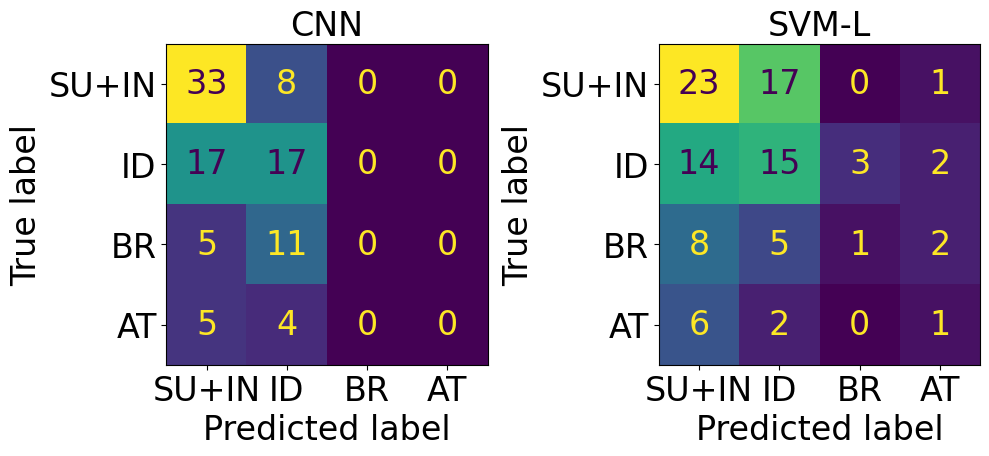

In [51]:
file_CNN_3_1 = record_results(classification='3+1', model='CNN_i1')
file_CNN_4 = record_results(classification='4', model='CNN_i1')
file_CNN_5 = record_results(classification='5', model='CNN_i1')

file_SVM_L_3_1 = record_results(classification='3+1', model='SVM_L_i1')
file_SVM_L_4 = record_results(classification='4', model='SVM_L_i1')
file_SVM_L_5 = record_results(classification='5', model='SVM_L_i1')


plot_CNN_31 = plot_confusion_matrix_data(file_CNN_3_1, file_SVM_L_3_1)
plt.savefig("conf_mat_3_1.png")
# 36.98 pt too wide for 9 cm
# 8.53 pt too wide for 8 cm


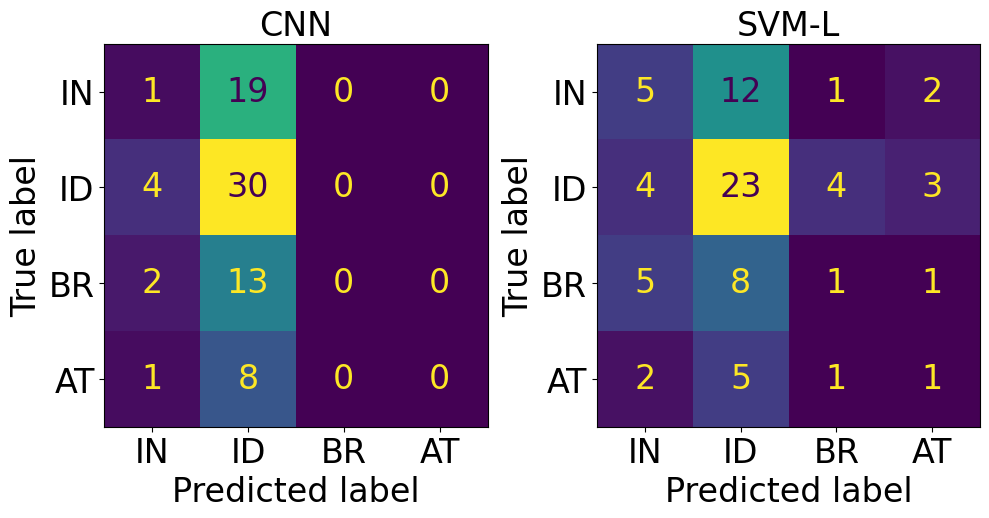

In [53]:
plot_CNN_4 = plot_confusion_matrix_data(file_CNN_4, file_SVM_L_4)
plt.savefig("conf_mat_4.png")
# 36.98 pt too wide for 9 cm
# 8.53 pt too wide for 8 cm


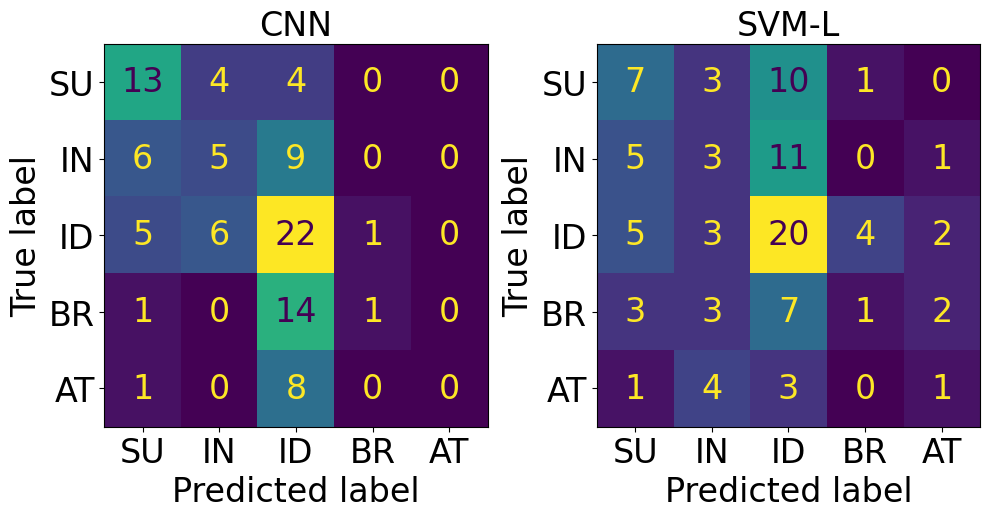

In [55]:
plot_CNN_5 = plot_confusion_matrix_data(file_CNN_5, file_SVM_L_5)
plt.savefig("conf_mat_5.png")
# 36.98 pt too wide for 9 cm
# 8.53 pt too wide for 8 cm


### References

Manas Gaur, Amanuel Alambo, Joy Prakash Sain, Ugur Kursuncu, Krishnaprasad Thirunarayan, Ramakanth Kavuluru, Amit Sheth, Randy Welton, and Jyotishman Pathak. Knowledge-aware assessment of severity of suicide risk for early intervention. In The World Wide Web Conference, pp. 514-525. ACM, 2019.

@inproceedings{gaur2019knowledge,
   title={Knowledge-aware assessment of severity of suicide risk for early intervention},
   author={Gaur, Manas
            and Alambo, Amanuel
            and Sain, Joy Prakash
            and Kursuncu, Ugur
            and Thirunarayan, Krishnaprasad
            and Kavuluru, Ramakanth
            and Sheth, Amit
            and Welton, Randy
            and Pathak, Jyotishman},
   booktitle={The World Wide Web Conference},
   pages={514--525},
   year={2019},
   organization={ACM}
}

Choi, Edward and Bahadori, Mohammad Taha and Song, Le and Stewart, Walter F and Sun, Jimeng. graph-based attention model for healthcare representation learning

@inproceedings{choi2017gram,
  title={GRAM: graph-based attention model for healthcare representation learning},
  author={Choi, Edward and Bahadori, Mohammad Taha and Song, Le and Stewart, Walter F and Sun, Jimeng},
  booktitle={Proceedings of the 23rd ACM SIGKDD international conference on knowledge discovery and data mining},
  pages={787--795},
  year={2017}
}

... Suicide Risk Severity Assessment tool\footnote{
    \url{https://github.com/jpsain/Suicide-Severity}
}